In [41]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy

import ase.io


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion
from utils.io import write

In [42]:
def rmse2(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [43]:
N = 100

train_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":{}".format(N))
frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in frames
])

In [44]:
hypers_sr = {
    'smearing':1,
    'max_angular':6,
    'max_radial':12,
    'cutoff_radius':5.,
    'potential_exponent':0,
    'radial_basis': 'gto',
    'compute_gradients':True
}

hypers_lr = {
    'smearing':1,
    'max_angular':6,
    'max_radial':12,
    'cutoff_radius':5.,
    'potential_exponent':1,
    'radial_basis': 'gto',
    'compute_gradients':True
}

hypers_rascaline = {
    "cutoff": 5,
    "atomic_gaussian_width": 1,
    "max_radial": 12,
    "max_angular": 6,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 1.}},
    "gradients": True
}

In [45]:
calculator_sr = PyLODESphericalExpansion(hypers_sr)
#calculator_sr = RascalineSphericalExpansion(hypers_rascaline)
descriptor_sr = calculator_sr.compute(train_frames)
test_sr = calculator_sr.compute(frames)

calculator_lr = PyLODESphericalExpansion(hypers_lr)
descriptor_lr = calculator_lr.compute(train_frames)
test_lr = calculator_lr.compute(frames)

inv_srsr = compute_power_spectrum(descriptor_sr)
inv_lrlr = compute_power_spectrum(descriptor_lr)
inv_multi = compute_power_spectrum(descriptor_sr, descriptor_lr)

inv_test_sr = compute_power_spectrum(test_sr)
inv_test_lr = compute_power_spectrum(test_lr)
inv_test_multi = compute_power_spectrum(test_sr, test_lr)

In [46]:
inv_srsr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_srsr.keys_to_samples('center_species')

inv_lrlr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_lrlr.keys_to_samples('center_species')

inv_multi.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_multi.keys_to_samples('center_species')

inv_test_sr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_sr.keys_to_samples('center_species')
inv_test_lr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_lr.keys_to_samples('center_species')
inv_test_multi.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_multi.keys_to_samples('center_species')

The total RMSE of energy/atom of the srsr model is:
[0.02115697]
0.04726005409215153
The total RMSE of energy/atom of the lrlr model is:
[0.02924706]
0.11399201733381013
The total RMSE of energy/atom of the multiscale model is:
[0.02952135]
0.08592465899749104


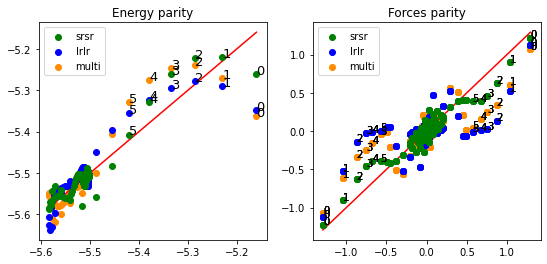

In [52]:
### Linear model
#model = LinearModel(normalize=True, regularizer=[1e-4, 5e-4])

### GAP model with full kernels
#model_srsr = FullKernelGap(zeta=2, regularizer=[1e-4, 1e-4])
#model_lrlr = FullKernelGap(zeta=2, regularizer=[1e-4, 1e-4])
#model_multi = FullKernelGap(zeta=2, regularizer=[1e-4, 1e-4])

### GAP model with sparse kernels
support_srsr = select_support_points(inv_srsr, n_select=60)
model_srsr = SparseKernelGap(support_points=support_srsr, zeta=2, regularizer=[1e-4, 1e-4])
support_lrlr = select_support_points(inv_lrlr, n_select=60)
model_lrlr = SparseKernelGap(support_points=support_lrlr, zeta=2, regularizer=[1e-4, 1e-4])
support_multi = select_support_points(inv_multi, n_select=60)
model_multi = SparseKernelGap(support_points=support_multi, zeta=2, regularizer=[1e-4, 1e-4])

model_srsr.fit(inv_srsr, train_energy, train_forces)
model_lrlr.fit(inv_lrlr, train_energy, train_forces)
model_multi.fit(inv_multi, train_energy, train_forces)

pred_energy_srsr, pred_forces_srsr = model_srsr.predict(inv_test_sr, with_forces=True)
pred_energy_lrlr, pred_forces_lrlr = model_lrlr.predict(inv_test_lr, with_forces=True)
pred_energy_multi, pred_forces_multi = model_multi.predict(inv_test_multi, with_forces=True)

test_energy_per_atom=[]
pred_energy_srsr_per_atom=[]
pred_energy_lrlr_per_atom=[]
pred_energy_multi_per_atom=[]

for i in np.arange(len(frames)):
    n_atoms = len(frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_srsr_per_atom.append(pred_energy_srsr[i]/n_atoms)
    pred_energy_lrlr_per_atom.append(pred_energy_lrlr[i]/n_atoms)
    pred_energy_multi_per_atom.append(pred_energy_multi[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_srsr_per_atom=np.array(pred_energy_srsr_per_atom)
pred_energy_lrlr_per_atom=np.array(pred_energy_lrlr_per_atom)
pred_energy_multi_per_atom=np.array(pred_energy_multi_per_atom)

print('The total RMSE of energy/atom of the srsr model is:')
print(rmse2(test_energy_per_atom, pred_energy_srsr_per_atom))
print(rmse2(test_forces.flatten(), pred_forces_srsr.flatten()))
print('The total RMSE of energy/atom of the lrlr model is:')
print(rmse2(test_energy_per_atom, pred_energy_lrlr_per_atom))
print(rmse2(test_forces.flatten(), pred_forces_lrlr.flatten()))
print('The total RMSE of energy/atom of the multiscale model is:')
print(rmse2(test_energy_per_atom, pred_energy_multi_per_atom))
print(rmse2(test_forces.flatten(), pred_forces_multi.flatten()))

fig, ax = plt.subplots(1,2,figsize=(9,4))
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax[0].set_title('Energy parity')
ax[0].plot(x, x, color="r")
ax[0].scatter(test_energy_per_atom, pred_energy_srsr_per_atom,color='green',label='srsr',zorder=3)
ax[0].scatter(test_energy_per_atom, pred_energy_lrlr_per_atom,color='blue',label='lrlr',zorder=2)
ax[0].scatter(test_energy_per_atom, pred_energy_multi_per_atom,color='darkorange',label='multi',zorder=1)
ax[0].legend()
xx = [test_forces.flatten().min(), test_forces.flatten().max()]
ax[1].set_title('Forces parity')
ax[1].plot(xx, xx, color="r")
ax[1].scatter(test_forces.flatten(), pred_forces_srsr.flatten(),color='green',label='srsr',zorder=3)
ax[1].scatter(test_forces.flatten(), pred_forces_lrlr.flatten(),color='blue',label='lrlr',zorder=2)
ax[1].scatter(test_forces.flatten(), pred_forces_multi.flatten(),color='darkorange',label='multi',zorder=1)
ax[1].legend()

### annotations

for ii in np.arange(len(test_energy_per_atom)):
    if test_energy_per_atom[ii] > -5.45:
        ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_srsr_per_atom[ii]),xycoords='data',
                      xytext=(test_energy_per_atom[ii],pred_energy_srsr_per_atom[ii]),textcoords='data',
                      fontsize=13)
        ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_lrlr_per_atom[ii]),xycoords='data',
                      xytext=(test_energy_per_atom[ii],pred_energy_lrlr_per_atom[ii]),textcoords='data',
                      fontsize=13)
        ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_multi_per_atom[ii]),xycoords='data',
                      xytext=(test_energy_per_atom[ii],pred_energy_multi_per_atom[ii]),textcoords='data',
                      fontsize=13)

for ii in np.arange(len(test_forces.flatten())):
    if np.abs(test_forces.flatten()[ii]) > 0.5:
        frameID = ii//24
        atomID = (ii-frameID*24)//3
        direcID = ii-frameID*24-atomID*3
        label = str(frameID) #+','+str(atomID)+','+str(direcID)
        ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_srsr.flatten()[ii]),xycoords='data',
                      xytext=(test_forces.flatten()[ii],pred_forces_srsr.flatten()[ii]),textcoords='data',
                      fontsize=10)
        ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_lrlr.flatten()[ii]),xycoords='data',
                      xytext=(test_forces.flatten()[ii],pred_forces_lrlr.flatten()[ii]),textcoords='data',
                      fontsize=10)
        ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_multi.flatten()[ii]),xycoords='data',
                      xytext=(test_forces.flatten()[ii],pred_forces_multi.flatten()[ii]),textcoords='data',
                      fontsize=10)

In [ ]:
dist_list = []

for frame in frames:
    dist = frame.get_positions()[0,1]-frame.get_positions()[6,1]
    dist_list.append(dist)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy_srsr,'--',label='srsr trained on all frames',linewidth=4,color='r')
ax.plot(dist_list, pred_energy_lrlr,'--',label='lrlr trained on all frames',linewidth=4,color='green')

ax.legend(markerscale=2,fontsize=13)